## **Challenge One: Data Analysis**  
**Question 1:  How many incidents were opened in each year (beginning with 2010)?**

In [1]:
# Necessary imports for the operations

# !pip install psycopg2-binary
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Function provided by Ezoic to access the Redshift Database

def query_db(query):
 '''
    Runs sql query on 311 database and returns a pandas DataFrame.
    Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the same
    '''
 host = 'interview-ds.ckgnwnm6pw4o.us-east-1.redshift.amazonaws.com'
 port = 5439
 db = 'interview'
 username = 'dsguest'
 password = 'nX9EFYUZ5Yu#0q'
 conn = psycopg2.connect(host=host, port=port, dbname=db, user=username, password=password)
 cur = conn.cursor()
 cur.execute(query)
 rows = cur.fetchall()
 rows = pd.DataFrame(rows)
 return rows

# Querying from Database

In [3]:
query = """
         SELECT created_date, closed_date, agency, complaint_type, borough 
         FROM public.three_one_one
         WHERE created_date between '2010/01/01'::date AND '2014/12/31'::date
        """

df_311 = query_db(query)

# Renaming the column of the Pandas Dataframe appropriately
df = df_311.rename(columns={0: 'created_date', 1:'closed_date', 2:'agency', 3:'complaint_type', 4:'borough'})

I have queried the required columns to analyze the data

In [4]:
df.head()

,created_date,closed_date,agency,complaint_type,borough
0,2010-01-01,2010-01-02,HPD,HEATING,Unspecified
1,2010-01-01,2010-01-02,HPD,HEATING,Unspecified
2,2010-01-01,2010-01-05,HPD,HEATING,Unspecified
3,2010-01-01,2010-01-16,HPD,PLUMBING,Unspecified
4,2010-01-01,2010-01-27,HPD,PAINT - PLASTER,Unspecified


# Data Cleaning & Preprocessing

In [5]:
# Drop null values from the dataframe
df = df.dropna()

Calculating the resolution time by the difference of the ticket creation date 
and closed date.

In [6]:
df['resolution_time'] = (df['closed_date'] - df['created_date']).dt.days
df = df[df['resolution_time'].notnull()]
df = df[df.resolution_time >= 0]

Dropping rows where Borough name is Unspecified or Empty

In [7]:
df = df[df.borough!='Unspecified']
df = df[df.borough!='']
df.head()

,created_date,closed_date,agency,complaint_type,borough,resolution_time
599,2010-01-01 00:04:22,2010-03-24 00:00:00,DOB,Building/Use,BRONX,81
600,2010-01-01 00:19:07,2010-01-01 08:31:26,NYPD,Noise - Residential,BRONX,0
668,2010-01-01 00:03:46,2010-01-01 01:13:06,NYPD,Noise - Residential,BROOKLYN,0
669,2010-01-01 00:08:02,2010-01-01 03:53:37,NYPD,Noise - Residential,BROOKLYN,0
670,2010-01-01 00:08:29,2010-01-01 00:27:41,NYPD,Noise - Residential,MANHATTAN,0


# Data Analysis & Visualization

# Distribution of Complaint Types across Boroughs from 2010 to 2015

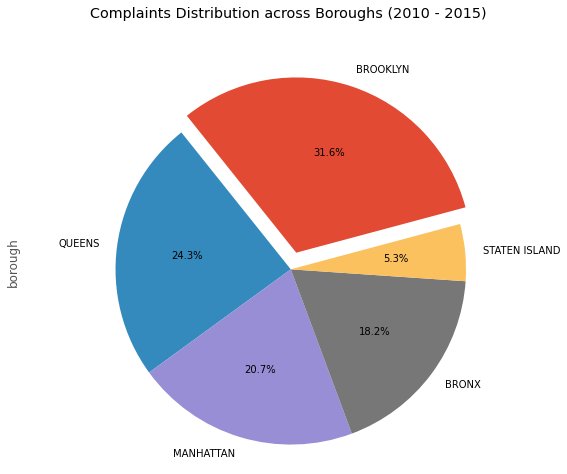

In [12]:
df['borough'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                        explode = (0.1, 0, 0, 0, 0), startangle = 15, shadow=False,
                        figsize = (8,6))
plt.axis('equal')
plt.tight_layout()
plt.title('Complaints Distribution across Boroughs (2010 - 2015)\n\n')
plt.show()

From the above Pie Chart we can observe that **Brooklyn** has the highest number of complaints reported, followed by **Queens**.

# Most Frequent Complaints in NYC from 2010 to 2015

Text(0, 0.5, 'Complaint Types\n')

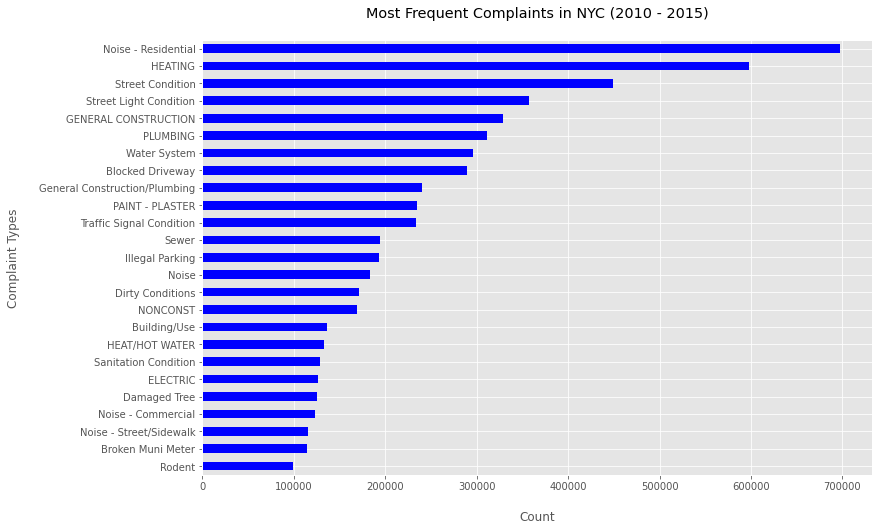

In [9]:
(df['complaint_type'].value_counts()).head(25).plot(kind='barh',
                                                    figsize=(12,8),title = 'Most Frequent Complaints in NYC', color ='blue')
plt.gca().invert_yaxis()
plt.title('Most Frequent Complaints in NYC (2010 - 2015)\n')
plt.xlabel('\nCount')
plt.ylabel('Complaint Types\n')

From the above Bar Chart we can observe that the complaints with **Highest Frequency** are:
 - Noise
 - Heating
 - Street Condition

The residents on New York are seriously troubled with constant Noise Pollution and Heating issues.

# Average Complaint Resolution Time in NYC from 2010 to 2015

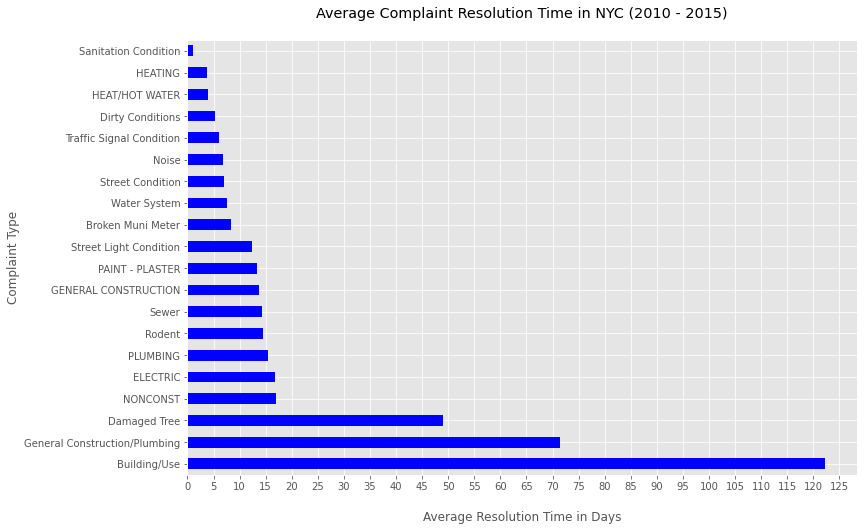

In [10]:
var = df.groupby('complaint_type').resolution_time.mean()
frequent = df['complaint_type'].value_counts().head(25)
var = var.loc[frequent.index].sort_values(ascending = False)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel('Complaint Type')
ax1.set_xlabel('\nAverage Resolution Time in Days')
ax1.set_title("Average Complaint Resolution Time in NYC (2010 - 2015)\n")
tick_spacing = 5
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
var.head(20).plot(kind = 'barh', color = 'blue', figsize=(12,8))

From the above Bar Chart we can observe:  

Complaints with the **fastest resolution** times (1-5 Days):
 - Sanitation 
 - Heating

Complaints with the **moderate resolution** times (5-15 Days):
 - Traffic Conditions 
 - Noise Complaints
 - Construction
 - Electric and more

Complaints with the **highest resolution** times (More than 45 Days):
 - Damaged Tree
 - Plumbing
 - Building

This shows that plumbing and tree related complaints are at worst resolution times. Probably the NYC 311 Service Board needs to look into these areas more.

# Average Resolution Time of Agencies in NYC from 2010 to 2015

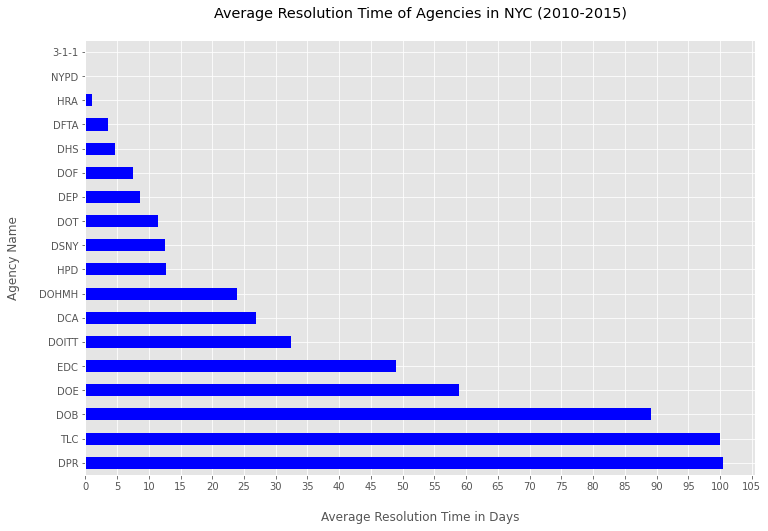

In [11]:
var = df.groupby('agency').resolution_time.mean()
frequent = df['agency'].value_counts().head(25)
var1 = var.loc[frequent.index].sort_values(ascending = False)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel('Agency Name\n')
ax1.set_xlabel('\nAverage Resolution Time in Days')
ax1.set_title("Average Resolution Time of Agencies in NYC (2010-2015)\n")
tick_spacing = 5
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
var1.head(25).plot(kind='barh', color = 'blue', figsize=(12,8))

From the above Bar Chart we can observe:  

Agencies with the **fastest resolution** times are:
 - NYPD
 - HRA
 - 3-1-1

Agencies with the **slowert resolution** times are:
 - DPR
 - TLC
 - DOB